**here the next assignm![mobilenetv2.png](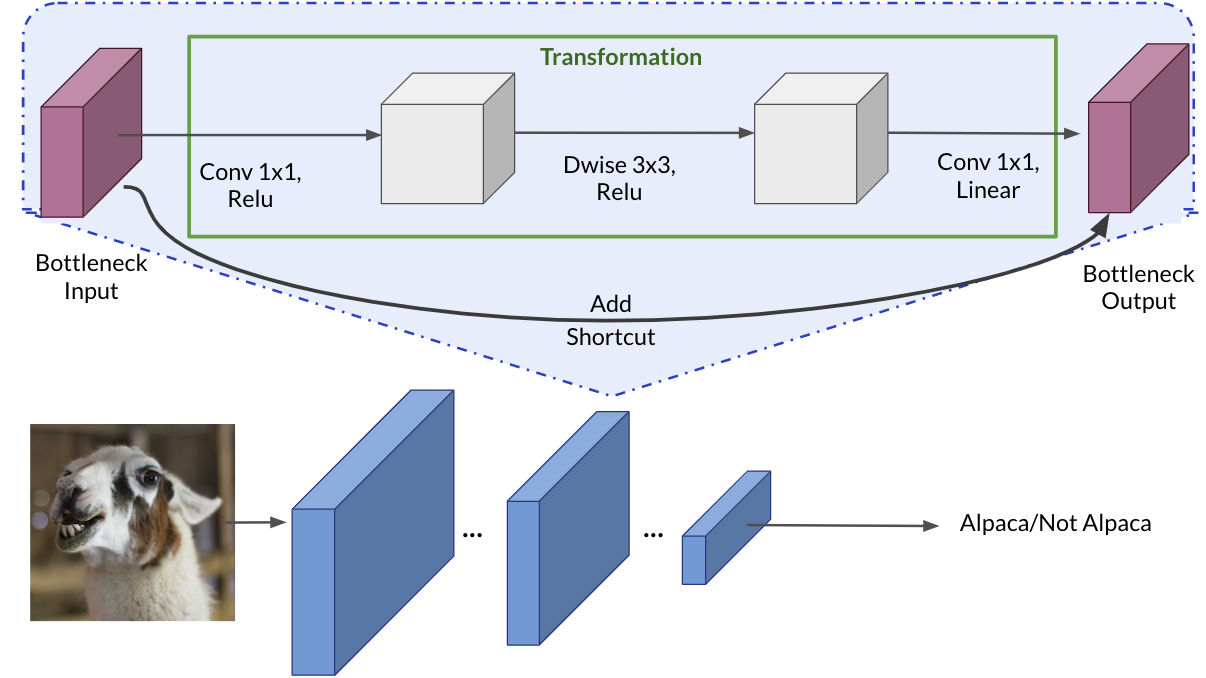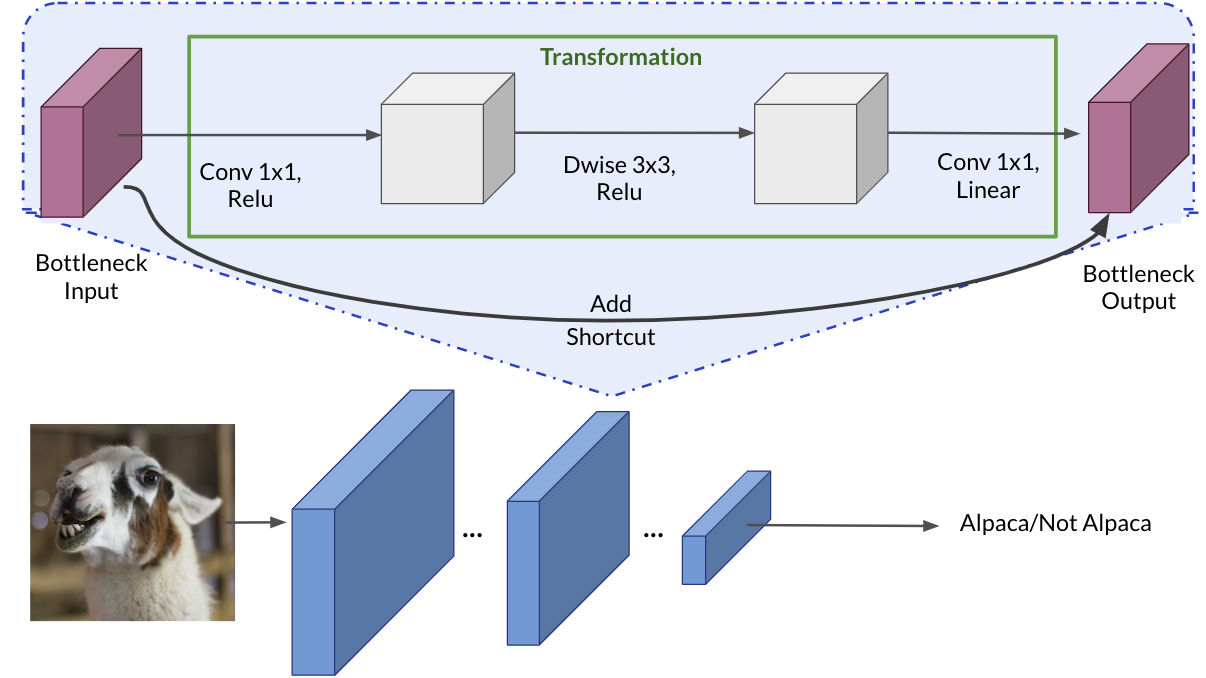)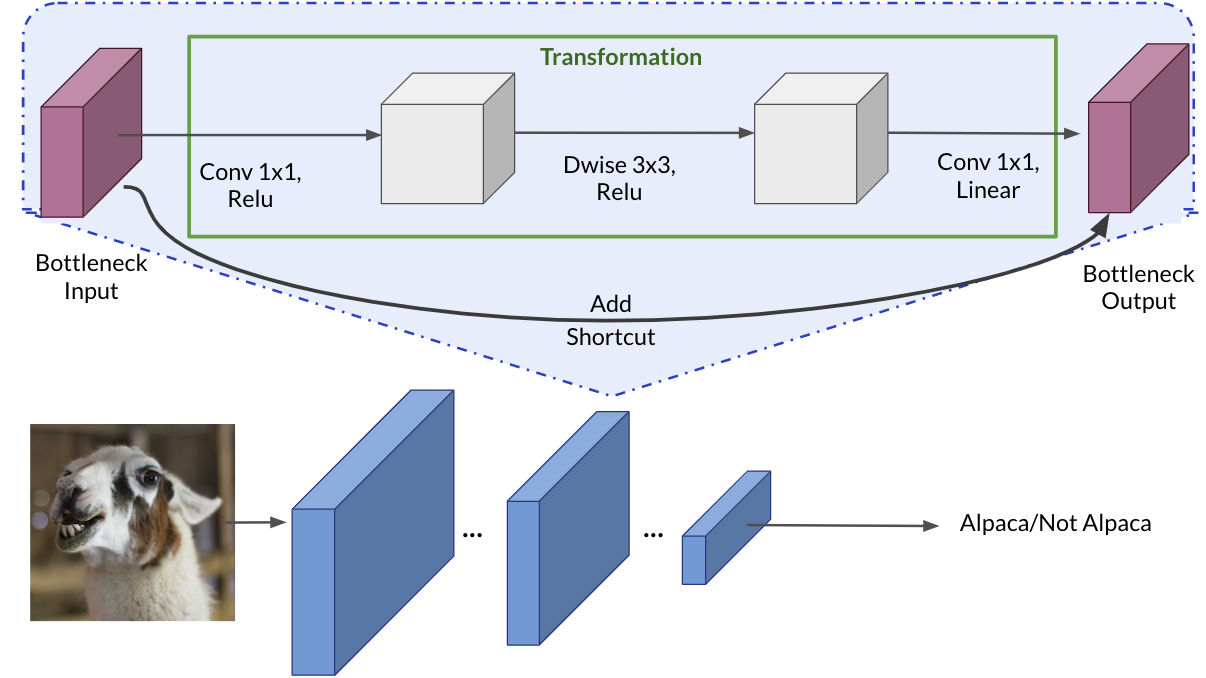ent is transferlearning with mobilenetv2 model .**

First let us enter to the directory where all of my files are present

In [10]:
%cd "/content/drive/MyDrive/Desktop/PythonP/week3"

/content/drive/MyDrive/Desktop/PythonP/week3


Import all the necessary packages and modules

In [2]:
# import all the packages
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation



Here is the link attached to download the dataset ":https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
From here u can download CIFAR-10  data set and then club all the images from separate files to a single folder

In [8]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os

def unpickle(file):
    with open(file, 'rb') as fo:
        return pickle.load(fo, encoding='bytes')

def save_images(images, labels, label_names, output_folder):
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    for i in range(len(images)):
        plt.figure(figsize=(3, 3))  # Adjust the figure size as needed
        plt.imshow(images[i])
        plt.axis('off')

        label_str = label_names[labels[i]].decode('utf-8')
        image_filename = f"{label_str}_{i}.png"
        image_path = os.path.join(output_folder, image_filename)

        plt.savefig(image_path)
        plt.close()  # Close the figure to prevent it from being displayed

# Change the file path to the location where you have the CIFAR-10 dataset
file_path = "/content/drive/MyDrive/Desktop/PythonP/week3/dataset/data_batch_5"

# Load data_batch_2
batch = unpickle(file_path)

# Extract images, labels, and label names
images = batch[b'data'].reshape((-1, 3, 32, 32)).transpose((0, 2, 3, 1))
labels = batch[b'labels']
label_names = unpickle("dataset/batches.meta")[b'label_names']

# Specify the output folder
output_folder = "/content/drive/MyDrive/Desktop/PythonP/week3/saved_images"

# Save each image one by one into the output folder
save_images(images[:10], labels[:10], label_names, output_folder)


Make sure when u are using the funciton image_dataset_from_directory() so the structure of your directory is expected to have 2 or more classes . Lets say we are in this assignment classifying wether the image is automobile  or not i have one main folder and 2 subfolders named as automobile and others . If this structure is not followed You will end up getting error **"No directory found"**

In [9]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Specify your dataset directory
directory = "saved_images"
BATCH_SIZE = 10
IMG_SIZE = (160, 160)

# Load the dataset
train_dataset = image_dataset_from_directory(
    directory,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.2,
    subset='training',
    seed=42
)

validation_dataset = image_dataset_from_directory(
    directory,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.2,
    subset='validation',
    seed=42
)


Found 42 files belonging to 2 classes.
Using 34 files for training.
Found 42 files belonging to 2 classes.
Using 8 files for validation.


Now as we know the data set is split into two training and validation . Before splitting of data  , data shuffle happened and 80percent is training set as 42*0.80 = 33.6 (34) images and remaining 20percent is as validation set = 8 images

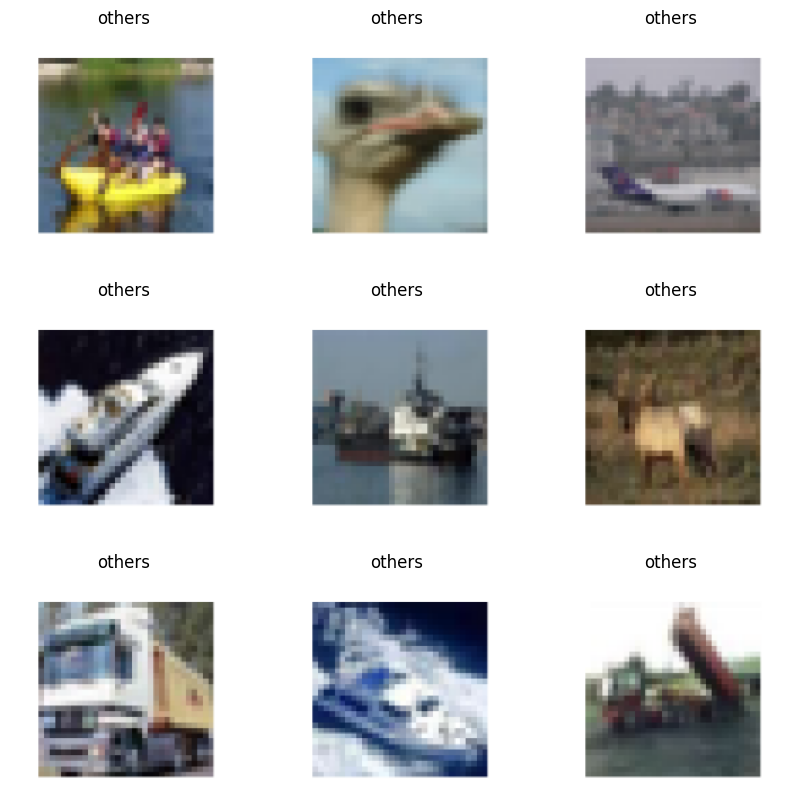

In [13]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Preprocess and Augment Training Data using keras sequential API

In [17]:
AUTO = tf.data.experimental.AUTOTUNE
print(AUTO)
train_dataset = train_dataset.prefetch(buffer_size=AUTO)
print(train_dataset)

-1
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


Exercise 1 - data_augmenter
Implement a function for data augmentation. Use a Sequential keras model composed of 2 layers:

RandomFlip('horizontal')
RandomRotation(0.2)

In [20]:
def data_augmenter():
  data_aug = tf.keras.Sequential()
  # adding data pipelining oeprations
  # random flipping
  data_aug.add(RandomFlip("horizontal"))
  # random rotation
  data_aug.add(RandomRotation(0.2))

  return data_aug

In [21]:
augmenter = data_augmenter()
assert(augmenter.layers[0].name.startswith('random_flip')), "First layer must be RandomFlip"
assert augmenter.layers[0].mode == 'horizontal', "RadomFlip parameter must be horizontal"
assert(augmenter.layers[1].name.startswith('random_rotation')), "Second layer must be RandomRotation"
assert augmenter.layers[1].factor == 0.2, "Rotation factor must be 0.2"
print('\033[92mAll tests passed!')

All tests passed!


Take a look at how an image from the training set has been augmented with simple transformations:
From one image, to 9 variations of that that image, in three lines of code. Now your model has a lot more to learn from.

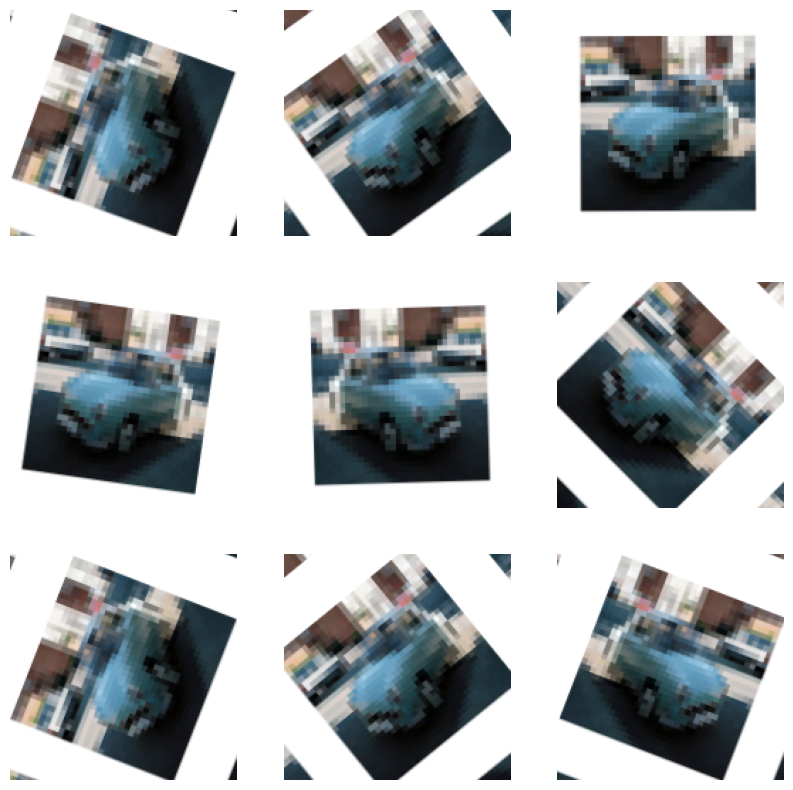

In [25]:
data_augmentation = data_augmenter()
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [24]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Using MobileNetV2 for Transfer Learning
MobileNetV2 was trained on ImageNet and is optimized to run on mobile and other low-power applications. It's 155 layers deep (just in case you felt the urge to plot the model yourself, prepare for a long journey!) and very efficient for object detection and image segmentation tasks, as well as classification tasks like this one. The architecture has three defining characteristics:

Depthwise separable convolutions
Thin input and output bottlenecks between layers
Shortcut connections between bottleneck layers

3.1 - Inside a MobileNetV2 Convolutional Building Block
MobileNetV2 uses depthwise separable convolutions as efficient building blocks. Traditional convolutions are often very resource-intensive, and depthwise separable convolutions are able to reduce the number of trainable parameters and operations and also speed up convolutions in two steps:

The first step calculates an intermediate result by convolving on each of the channels independently. This is the depthwise convolution.

In the second step, another convolution merges the outputs of the previous step into one. This gets a single result from a single feature at a time, and then is applied to all the filters in the output layer. This is the pointwise convolution, or: Shape of the depthwise convolution X Number of filters.

In [26]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

14536120/14536120 [==============================] - 0s 0us/step


In [27]:

base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [28]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(10, 1000)


In [29]:
#Shows the different label probabilities in one tensor
label_batch

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)>

In [30]:
base_model.trainable = False
image_var = tf.Variable(image_batch)
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

35363/35363 [==============================] - 0s 0us/step


[[('n04589890', 'window_screen', 0.67422384),
  ('n06359193', 'web_site', 0.032460604)],
 [('n04589890', 'window_screen', 0.18833654),
  ('n06359193', 'web_site', 0.13397196)],
 [('n04589890', 'window_screen', 0.9363694),
  ('n04590129', 'window_shade', 0.0058941687)],
 [('n04589890', 'window_screen', 0.49096245),
  ('n06359193', 'web_site', 0.073779054)],
 [('n02708093', 'analog_clock', 0.26864582),
  ('n04589890', 'window_screen', 0.13799618)],
 [('n04589890', 'window_screen', 0.9058792),
  ('n04590129', 'window_shade', 0.014775461)],
 [('n04589890', 'window_screen', 0.1933594),
  ('n02708093', 'analog_clock', 0.12625283)],
 [('n04589890', 'window_screen', 0.8187506),
  ('n03291819', 'envelope', 0.017811721)],
 [('n04589890', 'window_screen', 0.33559442),
  ('n04590129', 'window_shade', 0.08380269)],
 [('n04589890', 'window_screen', 0.8530025),
  ('n04258138', 'solar_dish', 0.025658669)]]

In [31]:
# UNQ_C2
# GRADED FUNCTION
def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''


    input_shape = image_shape + (3,)

    ### START CODE HERE

    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # From imageNet

    # Freeze the base model by making it non trainable
    base_model.trainable = False

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape)

    # apply data augmentation to the inputs
    x = data_augmentation(inputs)

    # data preprocessing using the same weights the model was trained on
    # Already Done -> preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    x = preprocess_input(x)

    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False)

    # Add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x)
    #include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.2)(x)

    # create a prediction layer with one neuron (as a classifier only needs one)
    prediction_layer = tfl.Dense(1)

    ### END CODE HERE

    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)

    return model


In [32]:
model2 = alpaca_model(IMG_SIZE, data_augmentation)

9406464/9406464 [==============================] - 0s 0us/step


In [34]:
base_learning_rate = 0.01
model2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)


Epoch 1/5
4/4 [==============================] - 10s 940ms/step - loss: 0.5219 - accuracy: 0.7353 - val_loss: 0.2535 - val_accuracy: 1.0000
Epoch 2/5
4/4 [==============================] - 0s 36ms/step - loss: 0.6151 - accuracy: 0.7647 - val_loss: 0.1471 - val_accuracy: 1.0000
Epoch 3/5
4/4 [==============================] - 0s 36ms/step - loss: 0.4951 - accuracy: 0.8235 - val_loss: 0.1129 - val_accuracy: 1.0000
Epoch 4/5
4/4 [==============================] - 0s 24ms/step - loss: 0.5559 - accuracy: 0.7647 - val_loss: 0.1412 - val_accuracy: 1.0000
Epoch 5/5
4/4 [==============================] - 0s 25ms/step - loss: 0.4789 - accuracy: 0.7647 - val_loss: 0.2046 - val_accuracy: 1.0000


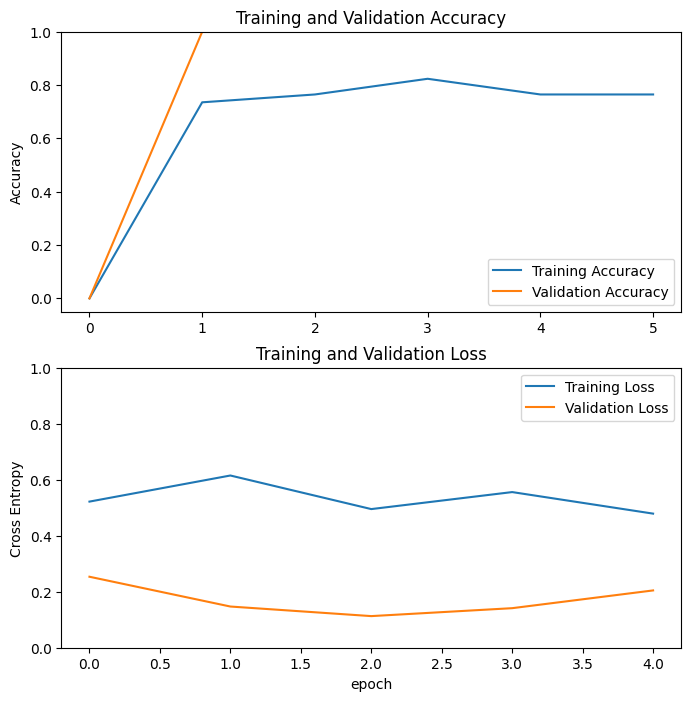

In [35]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [36]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [37]:
# UNQ_C3

base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 126

### START CODE HERE

##### One Way ########
"""
for layer in base_model.layers:
    if layer.name == 'block_16_expand':
        break
    layer.trainable = False
    print('Layer ' + layer.name + ' frozen.')
"""
######## Other Way ######
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    #print('Layer ' + layer.name + ' frozen.')
    layer.trainable = None

# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function= tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate*0.1)# 0.001
# Use accuracy as evaluation metric
metrics=['accuracy']

### END CODE HERE

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Number of layers in the base model:  156


In [39]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
4/4 [==============================] - 5s 352ms/step - loss: 0.4008 - accuracy: 0.8235 - val_loss: 0.1368 - val_accuracy: 1.0000
Epoch 6/10
4/4 [==============================] - 0s 30ms/step - loss: 0.4246 - accuracy: 0.8235 - val_loss: 0.1205 - val_accuracy: 1.0000
Epoch 7/10
4/4 [==============================] - 0s 39ms/step - loss: 0.3457 - accuracy: 0.8529 - val_loss: 0.1111 - val_accuracy: 1.0000
Epoch 8/10
4/4 [==============================] - 0s 28ms/step - loss: 0.4034 - accuracy: 0.9118 - val_loss: 0.1155 - val_accuracy: 1.0000
Epoch 9/10
4/4 [==============================] - 0s 39ms/step - loss: 0.3336 - accuracy: 0.8235 - val_loss: 0.1200 - val_accuracy: 1.0000
Epoch 10/10
4/4 [==============================] - 0s 39ms/step - loss: 0.3246 - accuracy: 0.8824 - val_loss: 0.1458 - val_accuracy: 1.0000


In [40]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

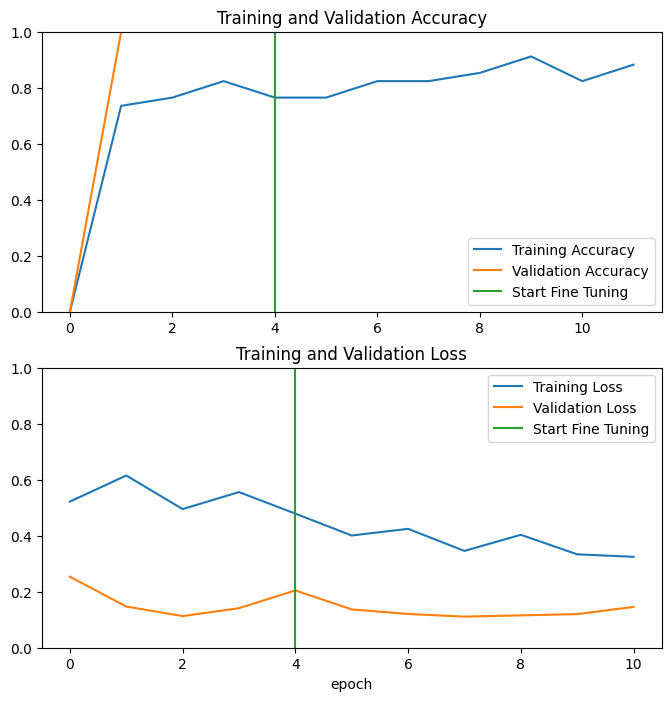

In [41]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
